In [ ]:
from rdflib import Graph, Literal, Namespace, RDF, XSD
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
import os
import json

In [ ]:

DIR = 'D:/gp data/Article-Bias-Prediction-main/data/jsons'
dir_list = os.listdir(DIR)
series = pd.read_json(os.path.join(DIR, dir_list[0]), typ='series')
df = pd.DataFrame(series)
files = []
for i, file in enumerate(dir_list):
    with open(os.path.join(DIR, file)) as f:
        row = json.load(f)
        row["ID"] = i
        files.append(row)
df = pd.DataFrame.from_records(files)
df.to_csv("Allsides_bias_dataset.csv")


In [ ]:
df.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,terrorism,New York Times - News,0,http://www.nytimes.com/2016/09/20/nyregion/ahm...,"Bomb Suspect Changed After Trip Abroad, Friend...",2016-09-20,N. R. Kleinfield,"Besides his most recent trip to Quetta , Mr. R...","Besides his most recent trip to Quetta, Mr. Ra...",www.nytimes.com,left,0
1,supreme_court,Vox,0,https://www.vox.com/policy-and-politics/2018/9...,Why Susan Collins claims she’s being bribed ov...,2018-09-12,"Emily Stewart, Terry Nguyen, Rebecca Jennings,...",Is Maine Republican Sen. Susan Collins being b...,Is Maine Republican Sen. Susan Collins being b...,www.vox.com,left,1
2,education,Ezra Klein,0,http://www.npr.org/blogs/thetwo-way/2014/05/06...,Poll: Prestigious Colleges Won't Make You Happ...,2014-05-06,Anya Kamenetz,Poll : Prestigious Colleges Wo n't Make You Ha...,Poll: Prestigious Colleges Won't Make You Happ...,www.npr.org,left,2
3,us_house,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Paul Ryan Reportedly Says No Chance for Border...,2017-09-12,Ian Mason,"House Speaker Paul Ryan , at a private dinner ...","House Speaker Paul Ryan, at a private dinner e...",www.breitbart.com,right,3
4,white_house,Guest Writer - Left,0,https://www.cnn.com/2019/07/11/politics/donald...,OPINION: Trump seeking change of legal fortune...,2019-07-11,Analysis Stephen Collinson,( CNN ) President Donald Trump has reason to h...,(CNN) President Donald Trump has reason to hop...,www.cnn.com,left,4


In [ ]:
df.isna().sum()

topic               0
source              0
bias                0
url                 0
title               0
date                0
authors             0
content             0
content_original    0
source_url          0
bias_text           0
ID                  0
dtype: int64

In [ ]:
df['processed_content'] = df['content_original'].str.lower()


In [ ]:
import string
df['processed_content'] = df['processed_content'].str.translate(str.maketrans('', '', string.punctuation))


In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['processed_content'] = df['processed_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['processed_content'] = df['processed_content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [ ]:
df['processed_content'].head()

0    besides recent trip quetta mr rahami visited k...
1    maine republican sen susan collins bribed vote...
2    poll prestigious college wont make happier lif...
3    house speaker paul ryan private dinner earlier...
4    cnn president donald trump reason hope luck ch...
Name: processed_content, dtype: object

In [ ]:
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf_vectorizer = TfidfVectorizer(max_features=1000)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_content'])

svd = TruncatedSVD(n_components=100)

reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)

df['tfidf'] = reduced_tfidf_matrix.tolist()

In [ ]:
df['tfidf'].head()

0    [0.28603965397069253, 0.02758896594567301, 0.1...
1    [0.32742045775005435, -0.028665558738778484, 0...
2    [0.21981294787399638, -0.13934844230962473, -0...
3    [0.3569778955172558, 0.0057932053298146635, 0....
4    [0.4799392646665526, 0.20872184631818888, -0.1...
Name: tfidf, dtype: object

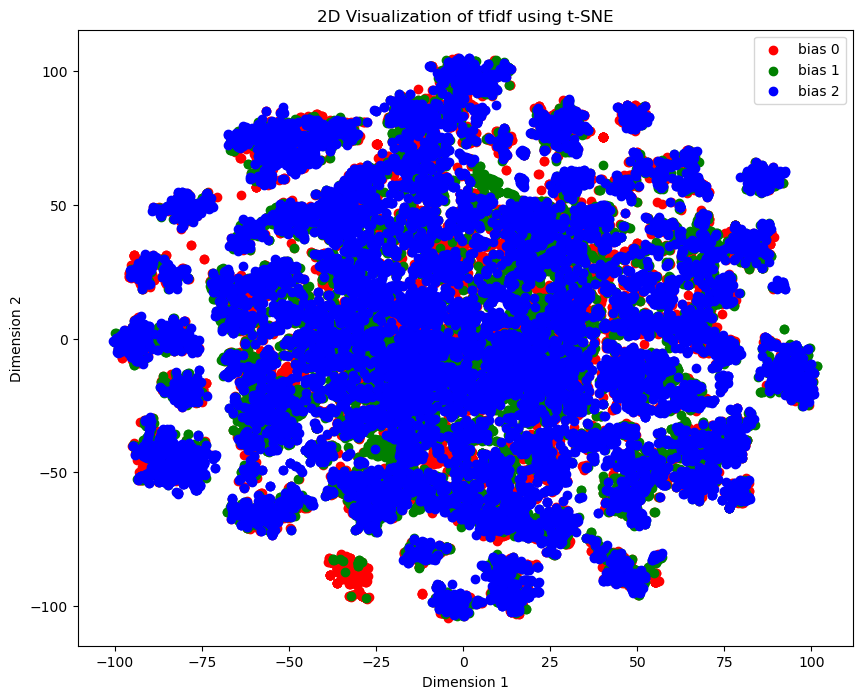

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Stack the tfidf vectors
embedding_matrix = np.stack(df['tfidf'].values)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embedding_matrix)

# Plot the result
plt.figure(figsize=(10, 8))

# Define colors (You can choose different colors)
colors = ['red', 'green', 'blue']

for i in range(3):  # Since you have 3 political leanings (0 to 2)
    idx = np.where(df['bias'] == i)
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=colors[i], label=f'bias {i}')

plt.title('2D Visualization of tfidf using t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()



In [ ]:
import gensim


model = gensim.models.Word2Vec(df['processed_content'].apply(str.split), vector_size=100, window=5, min_count=1, workers=4)

def average_word_vector(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in model.wv.key_to_index:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector.tolist()


df['word_embeddings'] = df['processed_content'].apply(lambda x: average_word_vector(x.split(), model, 100))


In [ ]:
df['word_embeddings'].head()

0    [0.4296230638403416, 0.08596898099991478, -0.5...
1    [0.7264249793176228, -0.35007122634872134, -0....
2    [0.2093557961708341, -0.16582050391877537, -0....
3    [0.8005146662757363, -0.4897562569755069, -0.6...
4    [0.9537196997252348, -0.44278905850605427, -1....
Name: word_embeddings, dtype: object

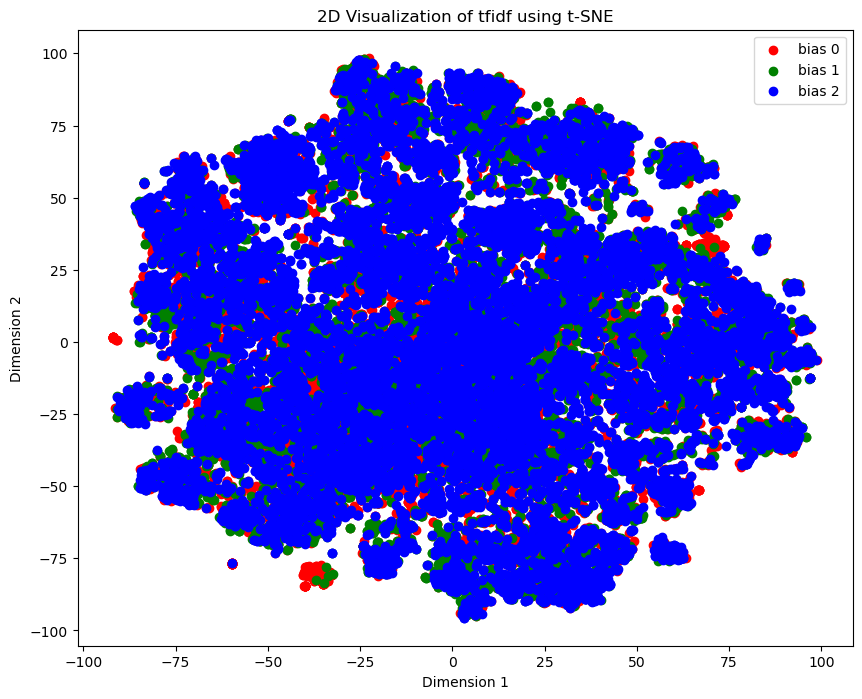

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Stack the tfidf vectors
embedding_matrix = np.stack(df['word_embeddings'].values)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embedding_matrix)

# Plot the result
plt.figure(figsize=(10, 8))

# Define colors (You can choose different colors)
colors = ['red', 'green', 'blue']

for i in range(3):  # Since you have 3 political leanings (0 to 2)
    idx = np.where(df['bias'] == i)
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=colors[i], label=f'bias {i}')

plt.title('2D Visualization of word embeddings using t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
### Logistic Regression

political_leaning = df['bias'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_2d, political_leaning, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.38330448675276263
Confusion Matrix:
[[ 944    0 1659]
 [ 611    0 1584]
 [ 778    0 1935]]
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.36      0.38      2603
           1       0.00      0.00      0.00      2195
           2       0.37      0.71      0.49      2713

    accuracy                           0.38      7511
   macro avg       0.26      0.36      0.29      7511
weighted avg       0.28      0.38      0.31      7511



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assuming df['political_leaning'] contains your target variable
political_leaning = df['bias'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_2d, political_leaning, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
random_forest.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = random_forest.predict(X_test)

# Evaluate the modelA
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.4474770336839302
Confusion Matrix:
[[1162  571  870]
 [ 632  869  694]
 [ 820  563 1330]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.45      0.45      2603
           1       0.43      0.40      0.41      2195
           2       0.46      0.49      0.47      2713

    accuracy                           0.45      7511
   macro avg       0.45      0.44      0.44      7511
weighted avg       0.45      0.45      0.45      7511



In [ ]:
political_leaning = df['bias'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_2d, political_leaning, test_size=0.2, random_state=42)

# Initialize the SVC model
svc = SVC()

# Fit the model on the training data
svc.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.4020769538010917
Confusion Matrix:
[[ 884  261 1458]
 [ 590  360 1245]
 [ 691  246 1776]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.34      0.37      2603
           1       0.42      0.16      0.24      2195
           2       0.40      0.65      0.49      2713

    accuracy                           0.40      7511
   macro avg       0.41      0.39      0.37      7511
weighted avg       0.41      0.40      0.38      7511



In [ ]:
# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the neural network architecture
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

accuracy



Epoch 1/100


752/752 - 6s - loss: 1.2693 - accuracy: 0.3435 - val_loss: 1.1279 - val_accuracy: 0.3625 - 6s/epoch - 9ms/step
Epoch 2/100
752/752 - 3s - loss: 1.1091 - accuracy: 0.3531 - val_loss: 1.1022 - val_accuracy: 0.3618 - 3s/epoch - 4ms/step
Epoch 3/100
752/752 - 3s - loss: 1.1001 - accuracy: 0.3565 - val_loss: 1.0975 - val_accuracy: 0.3618 - 3s/epoch - 4ms/step
Epoch 4/100
752/752 - 2s - loss: 1.0968 - accuracy: 0.3620 - val_loss: 1.0967 - val_accuracy: 0.3829 - 2s/epoch - 3ms/step
Epoch 5/100
752/752 - 3s - loss: 1.0950 - accuracy: 0.3647 - val_loss: 1.0979 - val_accuracy: 0.3618 - 3s/epoch - 4ms/step
Epoch 6/100
752/752 - 3s - loss: 1.0932 - accuracy: 0.3651 - val_loss: 1.0955 - val_accuracy: 0.3565 - 3s/epoch - 4ms/step
Epoch 7/100
752/752 - 3s - loss: 1.0937 - accuracy: 0.3649 - val_loss: 1.0955 - val_accuracy: 0.3618 - 3s/epoch - 3ms/step
Epoch 8/100
752/752 - 3s - loss: 1.0921 - accuracy: 0.3645 - val_loss: 1.0937 - val_accuracy: 0.3618 - 3s/epoch - 3ms/step
Epoch 9/100


0.38490214943885803

In [ ]:
import matplotlib.pyplot as plt
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

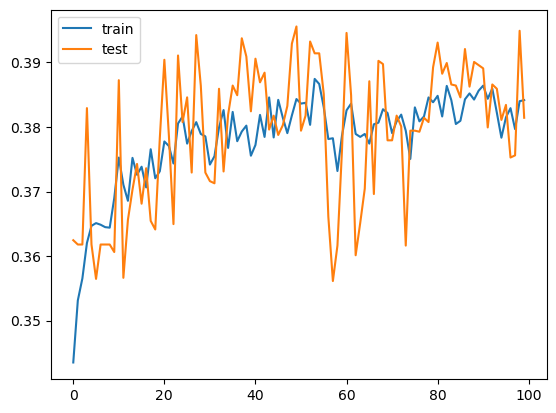

In [ ]:

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(['train', 'test'], loc='upper left')